In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 读取图像并转换为 NumPy 数组
path = '/home/pxl/myProject/血管分割/molong-深度插值/molong-work/Unet/wandb/latest-run/files/media/images/pred_prob_369_e564ac44951a60ac6798.png'
img = Image.open(path).convert('L')  # 将图像转换为灰度模式 ('L' 表示灰度图)
img_array = np.array(img)  # 将像素值标准化为 0 到 255

# 设定阈值为 164
threshold = 166

# 处理图像，超过阈值的部分设为255，其他部分保持不变
modified_array = np.where(img_array >= threshold, 255, img_array)
modified_array = np.where(img_array < threshold, 0, modified_array)


# 计算差分 loss (针对像素值为 255 的点)
def compute_laplacian_loss(image_array):
    loss = 0.0
    rows, cols = image_array.shape
    
    # 定义拉普拉斯算子核
    for i in range(1, rows-1):  # 跳过边界像素，避免越界
        for j in range(1, cols-1):
            if image_array[i, j] == 255:  # 只计算像素值为 255 的点
                # 计算离散拉普拉斯值
                laplacian_value = (4 * image_array[i, j] 
                                   - image_array[i+1, j]
                                   - image_array[i-1, j]
                                   - image_array[i, j+1]
                                   - image_array[i, j-1])
                
                # 累积损失
                loss += abs(laplacian_value)  # 可以采用绝对值避免负值对损失的抵消
    
    return loss

# 计算损失
loss = compute_laplacian_loss(modified_array)

# 显示处理后的图像
plt.imshow(modified_array, cmap='gray')
plt.title(f'Threshold >= {threshold}, Loss = {loss:.2f}')
plt.axis('off')  # 隐藏坐标轴

# 调整布局并显示
plt.tight_layout()
plt.show()

print(f"Accumulated Laplacian Loss: {loss:.2f}")

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 读取图像并转换为 NumPy 数组
path1 = '/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/数据集以及结果处理/label.png'
path2 = '/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/数据集以及结果处理/pred.png'

img1 = Image.open(path1).convert('L')  # 将图像转换为灰度模式 ('L' 表示灰度图)
img2 = Image.open(path2).convert('L')  # 将图像转换为灰度模式 ('L' 表示灰度图)
img_array1 = np.array(img1)  # 将像素值标准化为 0 到 255
img_array2 = np.array(img2)  # 将像素值标准化为 0 到 255

# TODO:只计算关键区域的

# 计算差分 loss (针对像素值为 255 的点)
def compute_laplacian_loss(image_array):
    loss = 0.0
    rows, cols = image_array.shape
    
    # 定义拉普拉斯算子核
    for i in range(1, rows-1):  # 跳过边界像素，避免越界
        for j in range(1, cols-1):
            if image_array[i, j] == 255:  # 只计算像素值为 255 的点
                # 计算离散拉普拉斯值
                
                # 计算变形差分, 该像素的相邻两个像素的值之和-2*当前像素值.
                # 其中创新点在于,相邻两个像素的确定方式,首先判断该像素的延伸/连通方向是什么.
                # 我的想法是,只需要判断四个方向,也就是东西、南北、东北西南、东南西北,四个方向,因为是8邻域. 然后从当下位置(x,y),往四个方向两侧开始往后寻找,比如东西就是num1,南北就是num2,等等,然后每往后迭代一次就是算一次是否存在最大值,如果不存在,则继续往后迭代,最多迭代8次,这是一个超参数,我可以修改.
                # 然后找到方向后,就按照这个方向,找左右相邻的两个像素,来计算变形差分,这样子可以更好的捕捉血管分割非连通结果.
                laplacian_value = (4 * image_array[i, j] 
                                   - image_array[i+1, j]
                                   - image_array[i-1, j]
                                   - image_array[i, j+1]
                                   - image_array[i, j-1])
                
                # 累积损失
                loss += abs(laplacian_value)  # 可以采用绝对值避免负值对损失的抵消
                
    return loss

# 计算损失
loss1 = compute_laplacian_loss(img_array1)
loss2 = compute_laplacian_loss(img_array2)
print(f"Accumulated Laplacian Loss: {loss1:.2f}")
print(f"Accumulated Laplacian Loss: {loss2:.2f}")


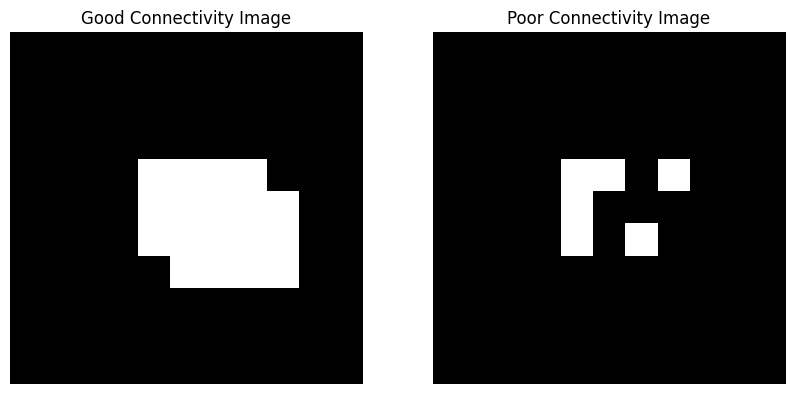

在坐标 (6, 6) 处，各方向上的像素数目为: [(2, 2), (1, 1), (2, 1), (2, 1)]
在坐标 (6, 6) 处，各方向上的像素数目为: [(0, 1), (0, 0), (0, 0), (1, 0)]


In [96]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def calculate_direction_pixel_count(image, x, y, maxPixel,max_check=5, debug=False):
    """
    计算图像中某个像素在四个方向上的连续像素数量。
    
    :param image: 二值化图像矩阵
    :param x: 当前像素的x坐标
    :param y: 当前像素的y坐标
    :param max_check: 每个方向最大检查的步数
    :return: 包含四个方向的像素数量的数组 [水平, 垂直, 45度对角线, 135度对角线]
    """
    directions = {
        'horizontal': (0, 1),  # 水平方向
        'diagonal_45': (-1, 1), # 45度方向
        'vertical': (-1, 0),    # 垂直方向
        'diagonal_135': (-1, -1) # 135度方向
    }
    counts = [(0,0), (0,0), (0,0), (0,0)]  # 用于存储每个方向的计数

    for i, (dx, dy) in enumerate(directions.values()):
        positive_count = 0
        negative_count = 0        # 正方向检查
        for step in range(1, max_check + 1):
            new_x = x + step * dx
            new_y = y + step * dy
            if debug: print(f"检查正方向: ({new_x}, {new_y})")
            if 0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0] and image[new_x, new_y] == maxPixel:
                positive_count += 1
            else:
                continue
        
        # 负方向检查
        for step in range(1, max_check + 1):
            new_x = x - step * dx
            new_y = y - step * dy
            if debug: print(f"检查负方向: ({new_x}, {new_y})")
            if 0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0] and image[new_x, new_y] == maxPixel:
                negative_count += 1
            else:
                continue
        
        counts[i] = (positive_count, negative_count)  # 更新计数为 (正方向, 负方向)
        if debug: print(f"方向 {i} 的累计值: {counts[i]}")
    return counts


# 示例：构建一个简单的测试图像
# 0代表背景像素，255代表前景像素（即分割结果）
# image = np.array([
#     [0,  0,   0,   0,   0],
#     [0, 255, 255, 255, 255],
#     [0, 255,  0,   0,   0],
#     [0, 255, 255, 255,  0],
#     [0,  0,   0,   0,   0]
# ], dtype=np.uint8)
path1 = '/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/数据集以及结果处理/good_connectivity_image.png'
path2 = '/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/数据集以及结果处理/bad_connectivity_image.png'
img1 = Image.open(path1).convert('L')  # 将图像转换为灰度模式 ('L' 表示灰度图)
img2 = Image.open(path2).convert('L')  # 将图像转换为灰度模式 ('L' 表示灰度图)
img_array1 = np.array(img1)  # 将像素值标准化为 0 到 255
img_array2 = np.array(img2)  # 将像素值标准化为 0 到 255
# 绘制图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Good Connectivity Image')
plt.imshow(img_array1, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Poor Connectivity Image')
plt.imshow(img_array2, cmap='gray')
plt.axis('off')
plt.show()

# 检查某个像素点的方向性
x, y = 6, 6  # 指定检查的像素坐标
direction_counts = calculate_direction_pixel_count(img_array1,x, y,255)
direction_counts2 = calculate_direction_pixel_count(img_array2, x, y,255)

print("在坐标 ({}, {}) 处，各方向上的像素数目为: {}".format(x, y, direction_counts))
print("在坐标 ({}, {}) 处，各方向上的像素数目为: {}".format(x, y, direction_counts2))

In [149]:
import numpy as np

def calculate_non_connectivity_error(image, direction_counts, x, y,debug=False):
    """
    计算非连通误差，基于相邻像素差值。
    
    :param image: 图像像素矩阵
    :param direction_counts: 四个方向上正负像素数量统计 [(正, 负), ...]
    :param x: 当前像素的x坐标
    :param y: 当前像素的y坐标
    :return: 误差值
    """
    # 定义四个方向对应的增量 (dx, dy)
    directions = {
        'horizontal': (0, 1),  # 水平方向
        'diagonal_45': (-1, 1),  # 45度方向
        'vertical': (-1, 0),  # 垂直方向
        'diagonal_135': (-1, -1)  # 135度方向
    }
    
    # 找到最大方向索引（正负数目和最大的）
    max_index = max(range(len(direction_counts)), key=lambda i: sum(direction_counts[i]))

    # 获取最大方向的正负数
    positive_count, negative_count = direction_counts[max_index]
    if debug:print(f"方向: {positive_count},{negative_count}")
    dx, dy = list(directions.values())[max_index]

    # 如果正负数目相同，使用策略1
    if positive_count == negative_count:
        errors = 0
        for step in [1, 2]:
            # 检查正负方向的两个位置
            pos_x, pos_y = x + step * dx, y + step * dy
            neg_x, neg_y = x - step * dx, y - step * dy
            if (0 <= pos_x < image.shape[1] and 0 <= pos_y < image.shape[0] and
                0 <= neg_x < image.shape[1] and 0 <= neg_y < image.shape[0]):
                if image[pos_y, pos_x] != image[neg_y, neg_x]:
                    errors += 1  # 如果不相等，则 errors + 1
        return errors

    # 使用策略2，侧重方向少的
    else:
        errors = 0
        if positive_count < negative_count:
            # 偏重正方向
            if debug:print("偏重正方向")
            for step in [1, 2, 3]:
                pos_x, pos_y = x + step * dx, y + step * dy
                neg_x, neg_y = x - 1 * dx, y - 1 * dy
                if (0 <= pos_x < image.shape[1] and 0 <= pos_y < image.shape[0] and
                    0 <= neg_x < image.shape[1] and 0 <= neg_y < image.shape[0]):
                    if image[pos_x, pos_y] != image[neg_x, neg_y]:
                        errors += 1  # 如果不相等，则 errors + 1
        else:
            # 偏重负方向
            if debug:print("偏重负方向")
            for step in [1, 2, 3]:
                pos_x, pos_y = x + 1 * dx, y + 1 * dy
                neg_x, neg_y = x - step * dx, y - step * dy
                if (0 <= pos_x < image.shape[1] and 0 <= pos_y < image.shape[0] and
                    0 <= neg_x < image.shape[1] and 0 <= neg_y < image.shape[0]):
                    if image[pos_x, pos_y] != image[neg_x, neg_y]:
                        errors += 1  # 如果不相等，则 errors + 1
        return errors

# 示例用法
# 定义示例方向统计 [(正方向像素数, 负方向像素数), ...]
# 示例图像矩阵
image_example = np.array([
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 , 255 , 255 , 255 , 255 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 , 255 , 255 , 255 , 255 , 255 ,  0 , 0],
    [  0 ,  0  , 0  , 0 , 255 , 255 , 255 , 255 , 255 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 , 255 , 255 , 255 , 255 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
], dtype=np.uint8)

image_example2 = np.array([
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 , 255 , 255 , 255 , 255 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 , 255 , 255 , 255 , 255 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 , 255 , 255 , 255 ,  0,    255 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 , 255 ,  0 ,  255 ,  255 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
])

x, y = 4,7
direction_counts_example = calculate_direction_pixel_count(image_example2, x, y,255,debug=False)
print(direction_counts_example)
# 调用函数
result = calculate_non_connectivity_error(image_example2, direction_counts_example, x, y)
print(f"计算({x},{y})处的非连通误差为:", result)


def cal_total(Test):
    loss = 0
    maxPixel = 255
    for x in range(Test.shape[0]):
        for y in range(Test.shape[1]):
            if(Test[x][y] == maxPixel):
                direction_counts = calculate_direction_pixel_count(Test, x, y, maxPixel,debug=False)
                lossItem = calculate_non_connectivity_error(Test, direction_counts, x, y)
                print(lossItem)
                loss += lossItem
                
    return loss
                
Test = image_example
loss = cal_total(Test)
print(loss)
print("第二轮测试开始~~~")
Test = image_example2
loss = cal_total(Test)
print(loss/19**2)



[(0, 3), (0, 2), (0, 2), (0, 0)]
计算(4,7)处的非连通误差为: 3
3
2
2
3
3
2
1
2
2
3
2
1
2
2
3
2
2
2
1.0833333333333333
第二轮测试开始~~~
3
2
2
3
3
2
2
3
3
2
2
0
3
3
2
0.09695290858725762


(-0.5, 10.5, 10.5, -0.5)

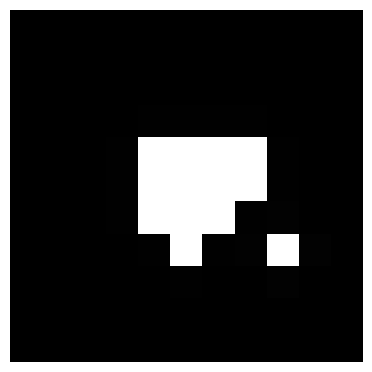

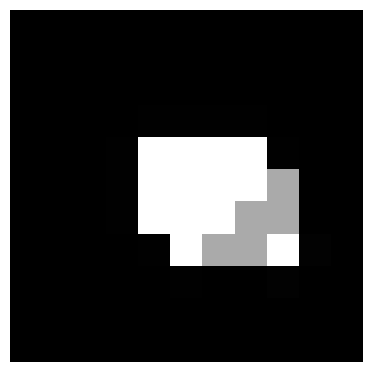

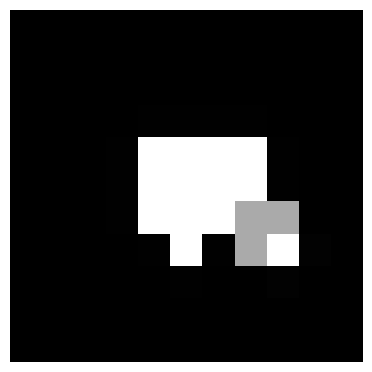

In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image_example2 = np.array([
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   1 ,   1 ,   1 ,   1 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 1 , 255 , 255 , 255 ,  255 ,  1 ,  0 , 0],
    [  0 ,  0  , 0  , 1 , 255 , 255 , 255 ,  255 ,  1 ,  0 , 0],
    [  0 ,  0  , 0  , 1 , 255 , 255 , 255 ,   1 ,   2 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   1 , 255 ,   1 ,   2 ,  255 , 2 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   1 ,   0 ,   0 ,   2 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
])


# 检测出周围

# 绘制图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_example2, cmap='gray')
plt.axis('off')

image_example2 = np.array([
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   1 ,   1 ,   1 ,   1 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 1 , 255 , 255 , 255 ,  255 ,  1 ,  0 , 0],
    [  0 ,  0  , 0  , 1 , 255 , 255 , 255 ,  255 , 170 ,  0 , 0],
    [  0 ,  0  , 0  , 1 , 255 , 255 , 255 ,  170 , 170 , 0 , 0],
    [  0 ,  0  , 0  , 0 ,   1 , 255 , 170 ,  170 , 255 , 2 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   1 ,   0 ,   0 ,   2 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_example2, cmap='gray')
plt.axis('off')

image_example2 = np.array([
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   1 ,   1 ,   1 ,   1 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 1 , 255 , 255 , 255 ,  255 ,  1 ,  0 , 0],
    [  0 ,  0  , 0  , 1 , 255 , 255 , 255 ,  255 ,  1 ,  0 , 0],
    [  0 ,  0  , 0  , 1 , 255 , 255 , 255 ,  170 , 170 , 0 , 0],
    [  0 ,  0  , 0  , 0 ,   1 , 255 ,  1 ,   170 , 255 , 2 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   1 ,   0 ,   0 ,   2 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,  0 , 0],
])


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_example2, cmap='gray')
plt.axis('off')

In [10]:
### 提取边缘

import numpy as np

def extract_edges(matrix):
    """
    提取矩阵中的边缘像素，边缘像素是那些值为255且至少有一个邻居是0的像素。
    
    :param matrix: 原始图像的二值矩阵
    :return: 同样大小的矩阵，边缘像素为1，其他像素为0
    """
    rows, cols = matrix.shape
    # 创建一个与原始矩阵大小相同的全零矩阵
    edge_matrix = np.zeros((rows, cols), dtype=int)
    
    # 遍历矩阵中每个像素
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # 检查当前像素是否为255
            if matrix[i, j] == 255:
                # 检查上下左右是否有任意一个是0
                if (matrix[i-1, j] == 0 or matrix[i+1, j] == 0 or 
                    matrix[i, j-1] == 0 or matrix[i, j+1] == 0):
                    # 将边缘像素位置设置为1
                    edge_matrix[i, j] = 1
    
    return edge_matrix

# 示例矩阵
image_example2 = np.array([
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,   0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,   0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,   0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,   0 , 0],
    [  0 ,  0  , 0  , 0 , 255 , 255 , 255 , 255 ,   0 ,   0 , 0],
    [  0 ,  0  , 0  , 0 , 255 , 255 , 255 , 255 ,   0 ,   0 , 0],
    [  0 ,  0  , 0  , 0 , 255 , 255 , 255 ,  0,    255 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 , 255 ,  0 ,  255 ,  255 ,  0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,   0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,   0 , 0],
    [  0 ,  0  , 0  , 0 ,   0 ,   0 ,   0 ,   0 ,   0 ,   0 , 0],
])

# 提取边缘像素
edge_result = extract_edges(image_example2)
edge_result


# 提取完后, 在原始图像中遍历每一个edge_result为true的位置把上下相邻的设置为1,如果已经是1就设置2, 采用value+1操作,不是设置为1.处理完就行.

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
def enhance_edges(matrix, edge_result, max_value=255):
    """
    在原始图像中遍历每一个 edge_result 为 1 的位置，将上下左右相邻的像素值进行增强，
    如果相邻位置已经是 1，则增加到 2，但如果值已达到 max_value，则不再增加。
    
    :param matrix: 原始图像的二值矩阵
    :param edge_result: 边缘检测结果矩阵，边缘位置为 1，其余为 0
    :param max_value: 最大允许的像素值，不再增加
    :return: 增强后的原始图像矩阵
    """
    rows, cols = matrix.shape
    
    # 遍历 edge_result 矩阵
    for i in range(1, rows - 1):  # 避免越界从第1行到倒数第2行
        for j in range(1, cols - 1):  # 避免越界从第1列到倒数第2列
            # 如果是边缘位置
            if edge_result[i, j] == 1:
                # 增强上方相邻位置的值，若未达到 max_value
                if matrix[i-1, j] < max_value:
                    matrix[i-1, j] += 1
                
                # 增强下方相邻位置的值，若未达到 max_value
                if matrix[i+1, j] < max_value:
                    matrix[i+1, j] += 1

                # 增强左方相邻位置的值，若未达到 max_value
                if matrix[i, j-1] < max_value:
                    matrix[i, j-1] += 1

                # 增强右方相邻位置的值，若未达到 max_value
                if matrix[i, j+1] < max_value:
                    matrix[i, j+1] += 1
    
    return matrix

# 示例原始矩阵
matrix_example = np.array([
    [0, 0, 0, 0, 0],
    [0, 255, 255, 255, 0],
    [0, 255, 0, 255, 0],
    [0, 255, 255, 255, 0],
    [0, 0, 0, 0, 0]
], dtype=np.uint8)

# 边缘矩阵
edge_example = extract_edges(matrix_example)

# 增强边缘
enhanced_result = enhance_edges(matrix_example.copy(), edge_example)

enhanced_result
# 示例原始矩阵
matrix_example = np.array([
    [0, 0, 0, 0, 0],
    [0, 255, 255, 255, 0],
    [0, 255, 0, 255, 0],
    [0, 255, 255, 255, 0],
    [0, 0, 0, 0, 0]
], dtype=np.uint8)

# 边缘矩阵
edge_result = extract_edges(image_example2)

# 增强边缘
enhanced_result = enhance_edges(image_example2.copy(), edge_result)

enhanced_result

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,   1,   1,   1,   0,   0,   0],
       [  0,   0,   0,   1, 255, 255, 255, 255,   1,   0,   0],
       [  0,   0,   0,   1, 255, 255, 255, 255,   2,   0,   0],
       [  0,   0,   0,   1, 255, 255, 255,   4, 255,   1,   0],
       [  0,   0,   0,   0,   2, 255,   3, 255, 255,   1,   0],
       [  0,   0,   0,   0,   0,   1,   0,   1,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]
增强后的矩阵:
 [[  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   1   1   1   1   1   0   0]
 [  0   0   0   1 255 255 255 255   1   0   0]
 [  0   0   0   1 255 255 255 255   1   0   0]
 [  0   0   0   1 255 255 255   2   2   1   0]
 [  0   0   0   1   1 255   1   2 255   1   0]
 [  0   0   0   0   1   1   1   1   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]


处理后的矩阵:
 [[  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   1   1   1   1   1   0   0]
 [  0   0   0   1 255 255 255 255   1   0   0]
 [  0   0   0   1 255 255 255 255   1   0   0]
 [  0   0   0   1 255 255 255 255 255   1   0]
 [  0   0   0   1   1 255   1 255 255   1   0]
 [  0   0   0   0   1   1   1   1   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]


(-0.5, 10.5, 10.5, -0.5)

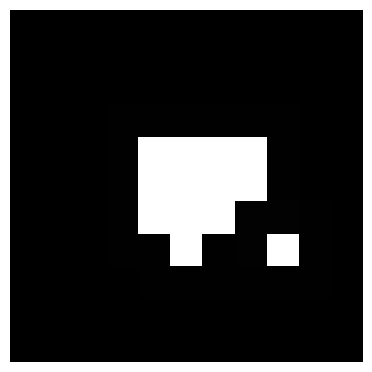

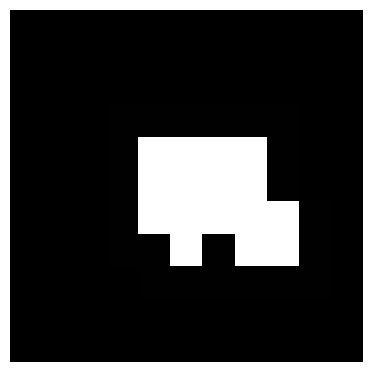

In [20]:
# 将像素值，处于大于1小于255的也设置为255

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def set_values_to_max(matrix, min_value=1, max_value=255):
    """
    将矩阵中处于 min_value 和 max_value 之间的像素值设置为 max_value。
    
    :param matrix: 原始图像矩阵
    :param min_value: 最小阈值，默认值为 1
    :param max_value: 设置为的最大值，默认值为 255
    :return: 处理后的矩阵
    """
    # 创建一个布尔掩码，查找所有大于 min_value 小于 max_value 的值
    mask = (matrix > min_value) & (matrix < max_value)
    # 将这些值设置为 max_value
    matrix[mask] = max_value
    return matrix

# 示例矩阵
enhanced_result = np.array([
 [  0,0 , 0  , 0,   0 ,  0,   0 ,  0,   0,   0,   0],
 [  0,0 , 0  , 0,   0 ,  0,   0 ,  0,   0,   0,   0],
 [  0,0 , 0  , 0,   0 ,  0,   0 ,  0,   0,   0,   0],
 [  0,0 , 0  , 1,   1 ,  1,   1 ,  1,   1,   0,   0],
 [  0,0 , 0  , 1, 255 ,255, 255 ,255,   1,   0,   0],
 [  0,0 , 0  , 1, 255 ,255, 255 ,255,   1,   0,   0],
 [  0,0 , 0  , 1, 255 ,255, 255 ,  2,   2,   1,   0],
 [  0,0 , 0  , 1,   1 ,255,   1 ,  2, 255,   1,   0],
 [  0,0 , 0  , 0,   1 ,  1,   1 ,  1,   1,   1,   0],
 [  0,0 , 0  , 0,   0 ,  0,   0 ,  0,   0,   0,   0],
 [  0,0 , 
  0  , 0,   0 ,  0,   0 ,  0,   0,   0,   0],
])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(enhanced_result, cmap='gray')
plt.axis('off')

# 设置符合条件的像素值为 255
result = set_values_to_max(enhanced_result)

# 打印处理后的矩阵
print("处理后的矩阵:\n", result)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(result, cmap='gray')
plt.axis('off')
